In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install cairosvg

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.1.0-cp36-none-any.whl size=88591 sha256=2a5469cbf3c872e6611e4bb2d1a99bfc7a2f408e3cfd0bc28fe55240125d2e12
  Stored in directory: /root/.cache/pip/wheels/11/5e/47/167d9dfd5fa5850dd0cd3db80afe6db46e620edec3419dce5a
Successfully built cairocffi


In [3]:
!pip install git+https://github.com/ufoym/imbalanced-dataset-sampler.git

  Cloning https://github.com/ufoym/imbalanced-dataset-sampler.git to /tmp/pip-req-build-5_vnvrxa
  Running command git clone -q https://github.com/ufoym/imbalanced-dataset-sampler.git /tmp/pip-req-build-5_vnvrxa
  Created wheel for torchsampler: filename=torchsampler-0.1-cp36-none-any.whl size=3650 sha256=67a73b8a20e1c6fae8a39d7a35d12e0a44186dfb0e51140adafab8aa4774345f
  Stored in directory: /tmp/pip-ephem-wheel-cache-gh4qnxlo/wheels/0c/eb/9c/93f536c9c63331244d37b40972cccae5ed3b3ecdf09aa5d5ba
Successfully built torchsampler


In [17]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=00aa85e3a81496e4c802eb53566354d3711bfff0829117be2e1e6cb140ea37c0
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [4]:
import math
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import copy
import tqdm
import time
from PIL import Image
from cairosvg import svg2png
from io import BytesIO
import multiprocessing
import subprocess
import torchsampler
from torch.autograd import Variable
from torchsampler import ImbalancedDatasetSampler
import albumentations
from albumentations import pytorch as AT
import ntpath
%matplotlib inline

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [5]:
!rm -rf './data/'
!unzip -q './drive/My Drive/data.zip' -d './data/'

In [6]:
!unzip -q './drive/My Drive/just_image.zip' -d './data/train/'

In [ ]:
!rm -rf './korpus/'
!unzip -q './drive/My Drive/korpus.zip' -d './korpus/'

In [ ]:
!zip -r -q './data.zip' './data/'

In [ ]:
len(os.listdir('./korpus/train/train/train/'))

In [7]:
class PrepareDataset(Dataset):
    def __init__(self, dir, transform=None, mode='train'):
        self.dir = dir
        self.mode = mode
        self.transform = transform
        self.label = 0
        self.name_to_label = {'bar_chart' : 1, 'radar_chart' : 2, 'flow_chart' : 3,
                              'graph' : 4, 'growth_chart' : 5, 'pie_chart' : 6,
                              'table' : 7, 'just_image' : 0}
        self.label_to_name = {1 : 'bar_chart', 2 : 'radar_chart', 3 : 'flow_chart',
                              4 : 'graph', 5 : 'growth_chart', 6 : 'pie_chart',
                              7 : 'table', 0: 'just_image'}

        self.file_list = [os.path.join(root, name)
             for root, dirs, files in os.walk(dir)
             for name in files
             if name.lower().endswith(('.gif','.bmp','.png','.jpg','.jpeg','.svg','.webp'))]     

    def __len__(self):
        return len(self.file_list)


    def getlabel(self, idx):
        if self.mode == 'train':
          path, name = ntpath.split(self.file_list[idx])
          ext = str(name).split('.')
          name = ext[0]
          for item, label in self.name_to_label.items():
            if item in name:
                      self.label = label
                      break
          return self.label            
        else: 
          return 0  

    def __getitem__(self, idx):
        path, name = ntpath.split(self.file_list[idx])
        ext = str(name).split('.')
        name = ext[0]
        ext = ext[len(ext)-1]
        fname = self.file_list[idx]
        #print(fname)
        if ext.lower() == 'gif':
          image = cv2.VideoCapture(fname)
          _, image = image.read()
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
          if ext.lower() == 'svg':
              with open(fname, mode='r') as svg_file:
                png = svg2png(file_obj=svg_file)
                image = Image.open(BytesIO(png)).convert('RGB')
                image = np.array(image)
          else:
                if ext.lower() == 'png':
                    image = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
                    #print(fname)
                    #print(image.shape)
                    if len(image.shape) > 2:
                     if image.shape[2] == 4:
                       trans_mask = image[:,:,3] == 0
                       image[trans_mask] = [255, 255, 255, 255]
                    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)  
                else:
                      image = cv2.imread(fname)
                      #print(fname)
                      #print(image.shape)
                      if len(image.shape) > 2:
                       image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB) 
                      else:
                       image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                      

        if self.mode == 'train':
            for item, label in self.name_to_label.items():
                if item in name:
                    self.label = label
                    break

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.mode == 'train':
            return image, self.label
        else:
            return image, name+'.'+ext


In [8]:
batch_size = 32
num_workers = 0 #1 if multiprocessing.cpu_count() < 3 else multiprocessing.cpu_count() - 1
img_size = 256
num_classes = 8

In [9]:
data_transforms_train = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.RandomSizedCrop((200, 256), 224, 224),
    albumentations.HorizontalFlip(),
    albumentations.Rotate(10),
    albumentations.HueSaturationValue(10, 10),
    albumentations.RandomBrightnessContrast(),
    albumentations.ToGray(p=0.5),
    albumentations.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0, shift_limit=0.03, p=0.5, border_mode=0),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_valid = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.CenterCrop(224, 224),
    #albumentations.ToGray(always_apply=True),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.CenterCrop(224, 224),
    #albumentations.ToGray(always_apply=True),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

In [10]:
train_dir = './data/train/'
test_dir = './data/test/'

In [ ]:
!rm './data/train/just_image/just_image_0427.jpg'

In [ ]:
for x in os.listdir(train_dir+'just_image/'):
  if not x.endswith('.gif'):
    if not x.endswith('.svg'):
      image = cv2.imread(train_dir+'just_image/' + x)
      print(x)
      if len(image.shape)<3:
        print(x)

In [11]:
trainset = PrepareDataset(train_dir, transform = data_transforms_train, mode = "train")
validset = PrepareDataset(train_dir, transform = data_transforms_valid, mode = "train")
testset = PrepareDataset(test_dir, transform = data_transforms_test, mode = "test")
print(len(trainset), len(validset), len(testset))

6868 6868 1753


In [12]:
valid_size = int(len(trainset) * 0.15)
indices = torch.randperm(len(trainset))
train_indices = indices[:len(indices)-valid_size]
valid_indices = indices[len(indices)-valid_size:]

def callback_get_label(dataset, idx):
  dataset.getlabel(idx)

trainloader = torch.utils.data.DataLoader(trainset, pin_memory=False, 
                                        batch_size=batch_size,
                                        sampler=ImbalancedDatasetSampler(trainset, indices=train_indices, callback_get_label=callback_get_label),
                                        num_workers = num_workers)
validloader = torch.utils.data.DataLoader(validset, pin_memory=False, 
                                        batch_size=batch_size,
                                        sampler=SubsetRandomSampler(valid_indices), num_workers = num_workers)
testloader = torch.utils.data.DataLoader(testset, pin_memory=False, 
                                         batch_size = batch_size, num_workers = num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['pie_chart', 'table', 'pie_chart', 'pie_chart', 'flow_chart', 'just_image', 'growth_chart', 'bar_chart']
['just_image', 'table', 'radar_chart', 'pie_chart', 'bar_chart', 'pie_chart', 'pie_chart', 'graph']
tensor([6, 7, 6, 6, 3, 0, 5, 1, 0, 7, 2, 6, 1, 6, 6, 4])
tensor([6, 7, 6, 6, 3, 0, 5, 1, 0, 7, 2, 6, 1, 6, 6, 4, 0, 6, 7, 3, 1, 6, 1, 4,
        3, 0, 6, 3, 6, 1, 1, 5])


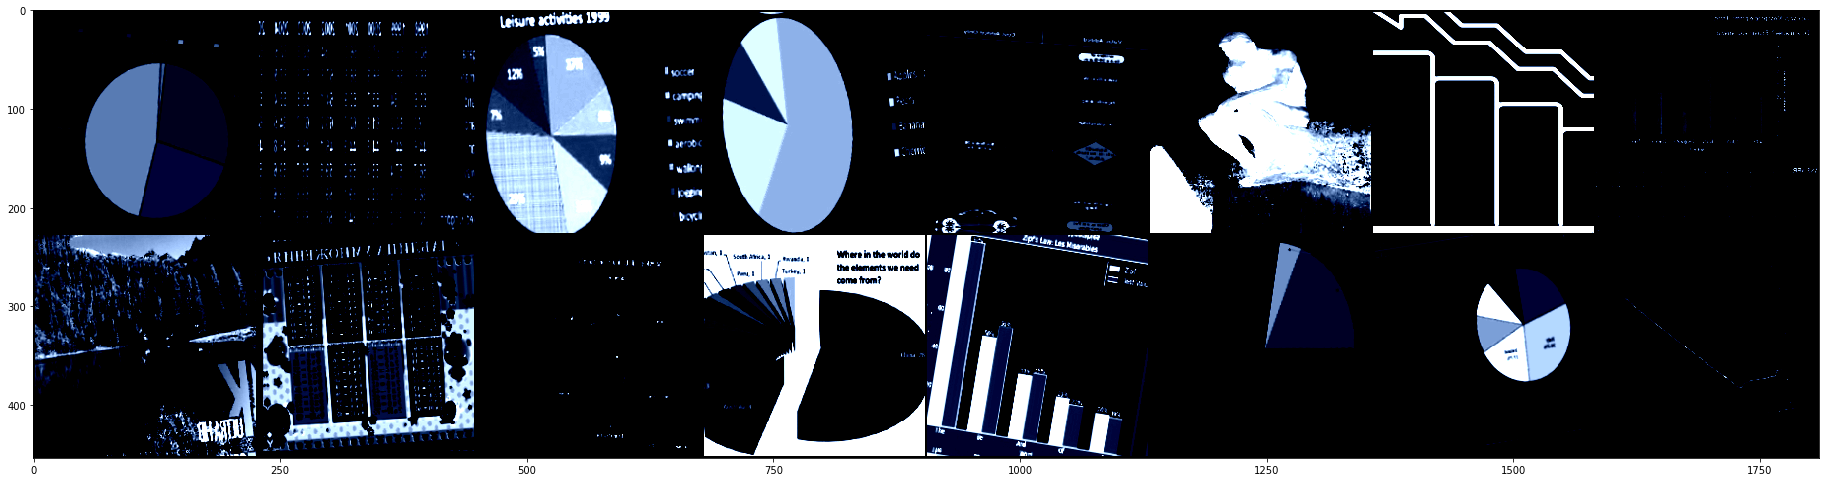

In [ ]:
samples, labels = next(iter(trainloader)) #проверим работоспособность
s = []
for i in labels[:16]:
  for label, name in trainset.label_to_name.items():
    if i == label:
      s.append(name)
      break
print(s[:8])  
print(s[8:16])      
print(labels[:16])
print(labels)
plt.figure(figsize=(32, 32))
grid_imgs = torchvision.utils.make_grid(samples[:16])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


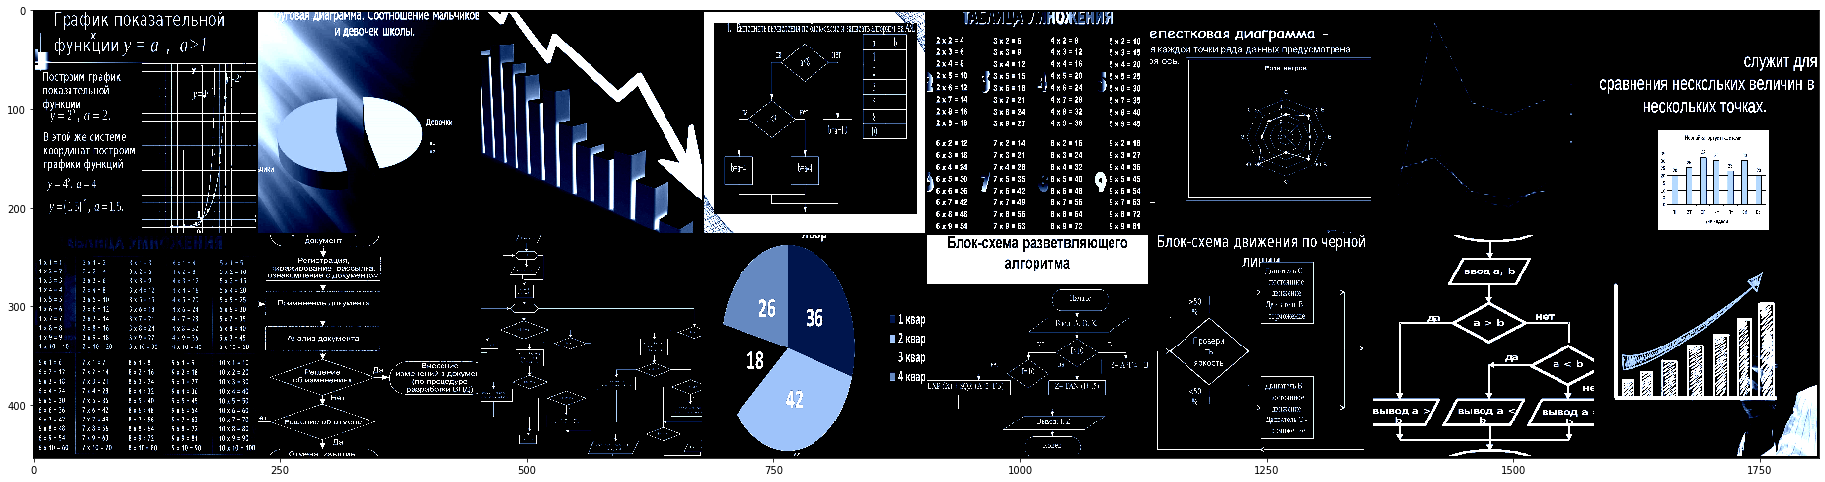

In [ ]:
samples, names = next(iter(testloader))
plt.figure(figsize=(32, 32))
grid_imgs = torchvision.utils.make_grid(samples[:16])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')

In [ ]:
for name in names[:8]:
    print(name)

46229ebb-30a7-4180-b48e-197298d04b03.jpg
46a041b2-195b-4b29-b2c9-a64311b4a43c.jpg
2a781bb0-8f0f-4e23-8eab-f90dc9d7be89.jpg
d84f9749-cbf0-4b88-81af-c759c9610aee.jpg
8d16f245-db51-41ac-a31d-e3b29c1eb014.jpg
f9d20323-9209-4694-aa43-e760ae389eea.jpg
e2308314-20af-45b9-899f-7eebb8155f7a.jpg
dceaf521-e9c8-4f24-90ca-3691bb969bbc.jpg


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
def resnet18_load(filename = '', newfc = True, pretrained = True):
  the_model = torchvision.models.resnet18(pretrained=pretrained, progress=True)
  for param in the_model.parameters():
    param.requires_grad = False  
  if newfc:
    in_features = the_model.fc.in_features
    the_model.fc = nn.Linear(in_features, num_classes)
  if len(filename) > 0:
    print('Loaded: '+filename)
    the_model.load_state_dict(torch.load(filename))
  return the_model

In [ ]:
def resnet50_load(filename = '', newfc = True, pretrained = True):
  the_model = torchvision.models.resnet50(pretrained=pretrained, progress=True)
  for param in the_model.parameters():
    param.requires_grad = False  
  if newfc:
    in_features = the_model.fc.in_features
    the_model.fc = nn.Linear(in_features, num_classes)
  if len(filename) > 0:
    print('Loaded: '+filename)
    the_model.load_state_dict(torch.load(filename))
  return the_model

In [14]:
def vgg19_load(filename = '', newfc = True,  pretrained = True):
  the_model = torchvision.models.vgg19_bn(pretrained=pretrained, progress=True)
  for param in the_model.parameters():
    param.requires_grad = False 
  if newfc:
    in_features = the_model.classifier._modules['6'].in_features
    the_model.classifier._modules['6'] = nn.Linear(in_features, num_classes)
  if len(filename) > 0:
    print('Loaded: '+filename)
    the_model.load_state_dict(torch.load(filename))
  return the_model

In [ ]:
def gnet_load(filename = '', newfc = True,  pretrained = True):
  the_model = torchvision.models.googlenet(pretrained=pretrained, progress=True)
  for param in the_model.parameters():
    param.requires_grad = False  
  if newfc:
    in_features = the_model.fc.in_features
    the_model.fc = nn.Linear(in_features, num_classes)
  if len(filename) > 0:
    print('Loaded: '+filename)
    the_model.load_state_dict(torch.load(filename))
  return the_model

In [18]:
from efficientnet_pytorch import EfficientNet
def effnet_load(filename = '', newfc = True,  pretrained = True):
      the_model = EfficientNet.from_pretrained('efficientnet-b0')
      for param in the_model.parameters():
        param.requires_grad = False 
      if newfc:
        in_features = the_model._fc.in_features
        the_model._fc = nn.Linear(in_features, num_classes)
      if len(filename) > 0:
        print('Loaded: '+filename)
        the_model.load_state_dict(torch.load(filename))
      return the_model

In [19]:
def train_model(the_model, dir, train_loader, valid_loader, criterion, optimizer, scheduler, epochs):
    the_model.to(device)
    valid_loss_min = np.Inf
    patience = 5
    p = 0
    stop = False
    
    for epoch in range(1, epochs):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []
        the_model.train() 
        for batch_i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), torch.nn.functional.one_hot(target, num_classes=num_classes).to(device)#target.to(device)#.unsqueeze(1)
            optimizer.zero_grad()
            output = the_model(data)
            loss = criterion(output, target.float())
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
    
        the_model.eval()
        val_loss = []
        #correct = 0

        class_correct = list(0. for i in range(num_classes))
        class_total = list(0. for i in range(num_classes))

        for batch_i, (data, target) in enumerate(valid_loader):
            label = target.clone().detach().to(device)
            data, target = data.to(device), torch.nn.functional.one_hot(target, num_classes=num_classes).to(device)#.unsqueeze(1)
            output = the_model(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item()) 

            _, predicted = torch.max(output.data, 1)

            c = (predicted == label)#.squeeze()
            correct = [i.item() for i in c]
            for i in range(len(correct)):
                l = label[i].item()
                class_correct[l] += c[i].item()
                class_total[l] += 1
            #for i in range(num_classes):
            #    l = label[i].item()
            #    class_correct[l] += c[i].item()
            #    class_total[l] += 1

        acc = 0

        for i in range(num_classes):
            if class_total[i] > 0: 
             acc += class_correct[i] / class_total[i]
             print('Accuracy of %5s : %2d%%' % (
                trainset.label_to_name.get(i), 100 * class_correct[i] / class_total[i]))
            else:
              print(trainset.label_to_name.get(i)+':'+str(i)+' is zero-count class..')   

        acc = 100 * acc / num_classes
        print(f'Epoch {epoch}, Acc: {acc:2.2f}%, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')



        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(the_model.state_dict(), dir+'model.pth')
            valid_loss_min = valid_loss
            p = 0

        if acc > 90.0:
          torch.save(the_model.state_dict(), dir+'model'+str(math.trunc(acc*100))+'.pth')

        if valid_loss > valid_loss_min:         # проверяем как дела на валидации
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return the_model, train_loss, val_loss

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = resnet18_load()

In [ ]:
model = vgg19_load() 

In [20]:
model = effnet_load('./drive/My Drive/models/effnet_my/model.pth')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
Loaded: ./drive/My Drive/models/effnet_my/model.pth


In [21]:
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2,)

In [22]:
model_inst, train_loss, val_loss = train_model(model, './drive/My Drive/models/effnet_my/', trainloader, validloader, criterion, 
                              optimizer, scheduler, epochs=30,)

Fri Aug 28 15:14:59 2020 Epoch: 1
Accuracy of just_image : 84%
Accuracy of bar_chart : 92%
Accuracy of radar_chart : 75%
Accuracy of flow_chart : 84%
Accuracy of graph : 76%
Accuracy of growth_chart : 24%
Accuracy of pie_chart : 98%
Accuracy of table : 96%
Epoch 1, Acc: 79.01%, train loss: 0.1622, valid loss: 0.1828.
Validation loss decreased (inf --> 0.182756).  Saving model ...
Fri Aug 28 15:16:40 2020 Epoch: 2
Accuracy of just_image : 83%
Accuracy of bar_chart : 90%
Accuracy of radar_chart : 80%
Accuracy of flow_chart : 87%
Accuracy of graph : 76%
Accuracy of growth_chart : 20%
Accuracy of pie_chart : 98%
Accuracy of table : 96%
Epoch 2, Acc: 79.06%, train loss: 0.1628, valid loss: 0.1847.
1 epochs of increasing val loss
Fri Aug 28 15:18:20 2020 Epoch: 3
Accuracy of just_image : 83%
Accuracy of bar_chart : 90%
Accuracy of radar_chart : 80%
Accuracy of flow_chart : 86%
Accuracy of graph : 76%
Accuracy of growth_chart : 20%
Accuracy of pie_chart : 98%
Accuracy of table : 95%
Epoch 3, 

In [15]:
model = vgg19_load('./drive/My Drive/models/vgg19_my/model9290.pth');

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



Loaded: ./drive/My Drive/models/vgg19_my/model9290.pth


In [ ]:
model = resnet18_load('./drive/My Drive/models/resnet_my/model9388.pth');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['radar_chart', 'table', 'table', 'radar_chart', 'radar_chart', 'graph', 'flow_chart', 'just_image']
['growth_chart', 'flow_chart', 'table', 'just_image', 'radar_chart', 'table', 'pie_chart', 'bar_chart']
[2 7 7 2 2 4 3 0 5 3 7 0 2 7 6 1]


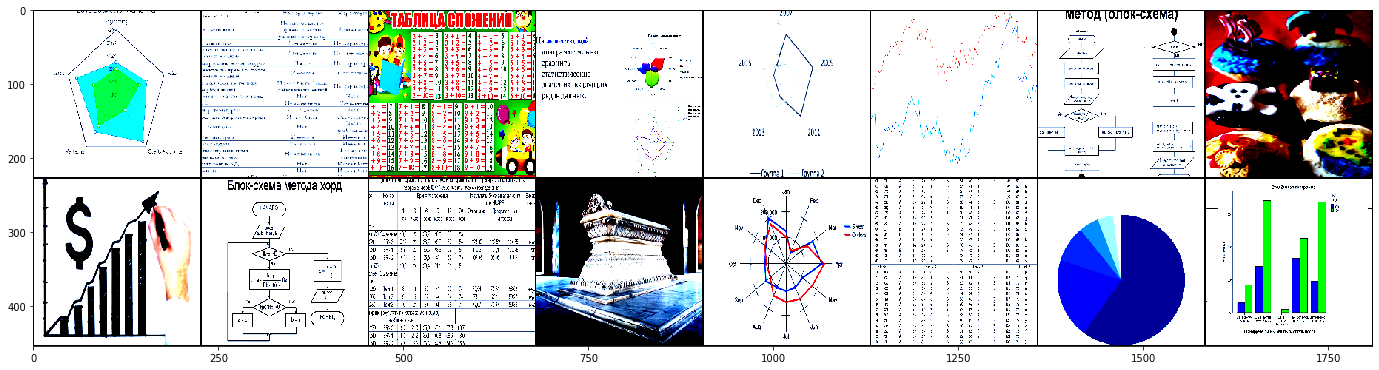

In [ ]:
model.to(device)
model.eval()
with torch.no_grad():
  for step, (data, name) in enumerate(testloader):
    if step < 1:
      continue
    data = data.to(device)
    output = model(data)
    output = torch.sigmoid(output)

    _, predicted = torch.max(output.data, 1)

    for i, x in enumerate(output.data):
     if torch.max(x) < 0.1:
      predicted[i] = 0

    plt.figure(figsize=(24, 24))
    grid_imgs = torchvision.utils.make_grid(data[:16])
    np_grid_imgs = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')
    break

s = []
labels = np.array(predicted.cpu())
for i in labels[:16]:
  for label, name in testset.label_to_name.items():
    if i == label:
      s.append(name)
      break

print(s[:8])  
print(s[8:16])      
print(labels[:16])
#print(output[:16])

In [ ]:
imagenet = resnet18_load(newfc = False).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.1566, 0.1681, 0.6748, 0.7756, 0.3629, 0.4649, 0.8030, 0.2937],
       device='cuda:0')
tensor([0.1285, 0.9741, 0.2124, 0.2847, 0.5566, 0.6655, 0.1966, 0.8422],
       device='cuda:0')
|
tensor([0.9970, 0.5180, 0.8930, 0.9897, 0.9478, 0.1604, 0.9785, 0.9879],
       device='cuda:0')
tensor([0.8041, 0.8650, 0.9979, 0.1494, 0.6572, 0.9317, 0.7553, 0.7457],
       device='cuda:0')
['just_image', 'growth_chart', 'table', 'bar_chart', 'table', 'table', 'bar_chart', 'graph']
['table', 'graph', 'flow_chart', 'pie_chart', 'flow_chart', 'flow_chart', 'radar_chart', 'table']


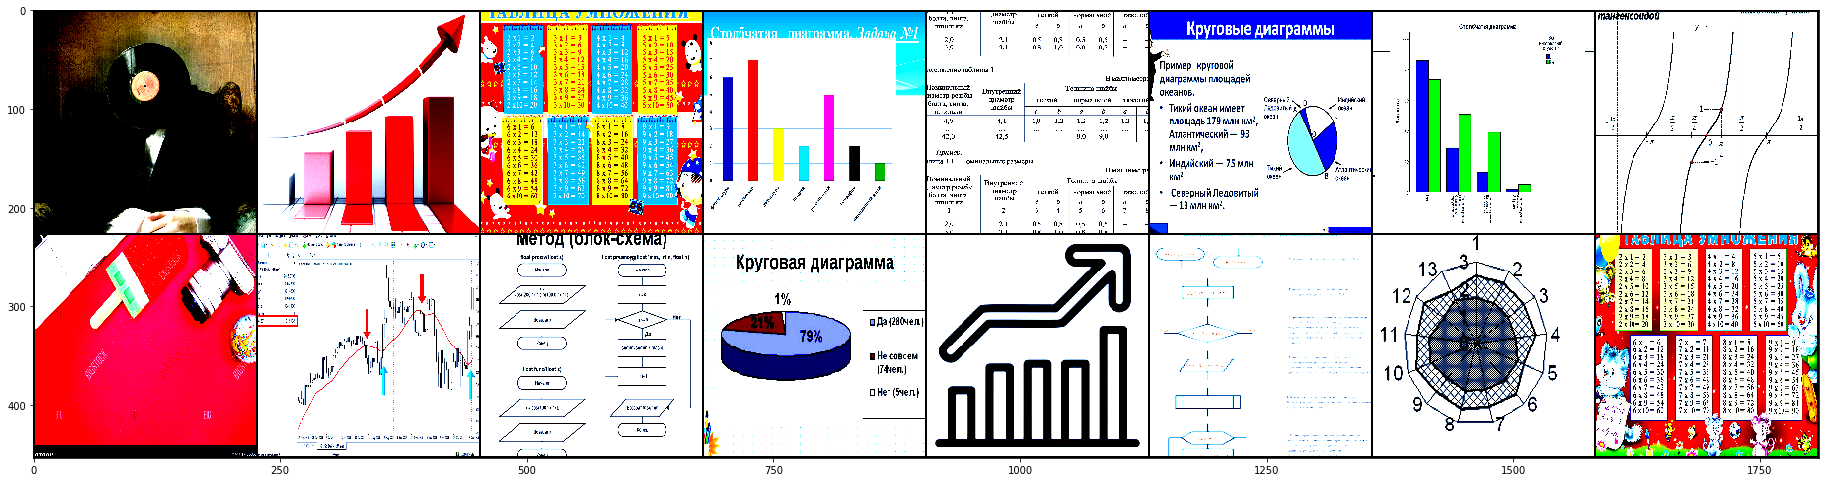

In [ ]:
for step, (samples, labels) in enumerate(testloader):
    if step == 8:
      break

plt.figure(figsize=(32, 32))
grid_imgs = torchvision.utils.make_grid(samples[:16])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')

imagenet.eval()
output = imagenet(samples.to(device))
output = torch.softmax(output, 1)
p_def, _ = torch.max(output.data, 1)
#p_def = torch.where(p_def < 0.9, torch.zeros_like(p_def), p_def)
print(p_def[:8])
print(p_def[8:16])

print('|')

model.eval()
output = model(samples.to(device))
output = torch.sigmoid(output)
p_act, idx = torch.max(output.data, 1)
#p_act = torch.mean(output.data, 1)
#p_act = torch.where(p_act < 0.3, torch.zeros_like(p_act), p_act)
print(p_act[:8])
print(p_act[8:16])

#p = torch.where(p_act < 0.4, torch.zeros_like(p_def), p_def)
s = []
for i in idx:
  for label, name in testset.label_to_name.items():
    if i == label:
      s.append(name)
      break

#for i in range(16):
#  if p_def[i] > p_act[i] and p_act[i] < 0.3:
#    s[i] = 'just_image'

print(s[:8])  
print(s[8:16]) 

vgg19_my/_model8915.pth + resnet_my/_model8787.pth = 8987


vgg19_my/model9290.pth + rsnet_my/model9443.pth = 9001

In [ ]:
#SUBMISSION AB
modelA = vgg19_load('./drive/My Drive/models/vgg19_my/model9290.pth')
modelB = resnet18_load('./drive/My Drive/models/resnet_my/model9443.pth')
modelA.to(device)
modelB.to(device)
modelA.eval()
modelB.eval()
pred_list = []
names_list = []
with torch.no_grad():
  for step, (data, names) in enumerate(testloader):
    data = data.to(device)

    outputA = modelA(data)
    outputA = torch.sigmoid(outputA)

    outputB = modelB(data)
    outputB = torch.sigmoid(outputB)

    output = (outputA + outputB) / 2

    _, predicted = torch.max(output.data, 1)
    out = [p.item() for p in predicted]
  
    pred_list += out
    names_list += names

submission = pd.DataFrame({'image_name' : names_list, 'label' : pred_list})
submission.to_csv('./submission.csv', index=False)
len(submission)

Loaded: ./drive/My Drive/models/vgg19_my/model9290.pth
Loaded: ./drive/My Drive/models/resnet_my/model9443.pth


1753

In [16]:
#SUBMISSION
#model = resnet18_load('./drive/My Drive/models/resnet_my/model9443.pth')
model.to(device)
#imagenet.to(device)
model.eval()
pred_list = []
names_list = []
with torch.no_grad():
  for step, (data, names) in enumerate(testloader):
    data = data.to(device)

    #imagenet.eval()
    #output = imagenet(data)
    #output = torch.softmax(output, 1)
    #p_def, _ = torch.max(output.data, 1)

    model.eval()
    output = model(data)
    output = torch.sigmoid(output)
    p_act, _ = torch.max(output.data, 1)

    _, predicted = torch.max(output.data, 1)

    #for i in range(len(predicted)):
      #if p_def[i] > p_act[i] and p_act[i] < 0.30:
    #  if p_act[i] < 0.30:
    #    predicted[i] = 0    

    out = [p.item() for p in predicted]
    
    #for i, x in enumerate(out):
    #  if x == 0:
    #    out[i] = 7
    #  else:
    #    if x == 7:
    #      out[i] = 0  

    pred_list += out
    names_list += names

submission = pd.DataFrame({'image_name' : names_list, 'label' : pred_list})
submission.to_csv('./submission.csv', index=False)
len(submission)

1753

In [ ]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.avgpool1 = nn.AdaptiveAvgPool2d(8)
        self.fc1 = nn.Linear(8*8*64, 7)
    
    def forward(self, x):
        #print(x.shape)
        x = self.cnn1(x)
        #print(x.shape)
        x = self.bn1(x)
        #print(x.shape)
        x = self.relu1(x)
        #print(x.shape)
        x = self.avgpool1(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc1(x) 
        #print(x.shape)
        #print(x)
        return x

In [ ]:
def predict_ensemble(the_model, inputs):
    the_model.to(device)
    the_model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        output = the_model(inputs)
        output = torch.sigmoid(output)
    return output

In [ ]:
class Ensemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(Ensemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.sigmoid = nn.Sigmoid()
        self.classifier = nn.Linear(14, 7)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.sigmoid(x)
        x = self.classifier(x)
        return x

In [ ]:
modelA = vgg19_load('./vgg19_20.pth')
modelB = resnet18_load('./rnet18_20.pth')
ensemble = Ensemble(modelA, modelB)


Loaded: ./vgg19_20.pth
Loaded: ./rnet18_20.pth


In [ ]:
def train_ensemble(ensemble, train_loader, valid_loader, epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ensemble.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2,)
    
    ensemble.to(device)
    valid_loss_min = np.Inf
    patience = 5
    p = 0
    stop = False
    
    for epoch in range(1, epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []
        ensemble.train() 
        for batch_i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), torch.nn.functional.one_hot(target, num_classes=7).to(device)#target.to(device)#.unsqueeze(1)
            optimizer.zero_grad()
            output = ensemble(data, data)
            loss = criterion(output, target.float())
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
    
        ensemble.eval()
        val_loss = []
        correct = 0
        for batch_i, (data, target) in enumerate(valid_loader):
            label = target.clone().detach()
            data, target = data.to(device), torch.nn.functional.one_hot(target, num_classes=7).to(device)#.unsqueeze(1)
            output = ensemble(data, data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item()) 

            _, predicted = torch.max(output.data, 1) #torch.sigmoid(
            correct += (predicted == label.to(device)).sum().item()

        acc = correct / len(test_files)
        print(f'Epoch {epoch}, Acc: {acc}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(ensemble.state_dict(), './ensemble.pth')
            valid_loss_min = valid_loss
            p = 0

        if acc > 0.90:
          torch.save(ensemble.state_dict(), './ensemble90.pth')

        if valid_loss > valid_loss_min:         # проверяем как дела на валидации
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return ensemble, train_loss, val_loss

In [ ]:
model_inst, train_loss, val_loss = train_ensemble(ensemble, trainloader, validloader, epochs=5,)

Sun Aug 23 16:40:29 2020 Epoch: 1
Epoch 1, Acc: 0.058756417569880204, train loss: 0.6928, valid loss: 0.6745.
Validation loss decreased (inf --> 0.674482).  Saving model ...
Sun Aug 23 16:42:04 2020 Epoch: 2
Epoch 2, Acc: 0.05818596691386195, train loss: 0.6569, valid loss: 0.6391.
Validation loss decreased (0.674482 --> 0.639131).  Saving model ...
Sun Aug 23 16:43:39 2020 Epoch: 3
Epoch 3, Acc: 0.058756417569880204, train loss: 0.6181, valid loss: 0.5959.
Validation loss decreased (0.639131 --> 0.595894).  Saving model ...
Sun Aug 23 16:45:14 2020 Epoch: 4
Epoch 4, Acc: 0.06332002281802625, train loss: 0.5733, valid loss: 0.5513.
Validation loss decreased (0.595894 --> 0.551277).  Saving model ...
Sun Aug 23 16:46:50 2020 Epoch: 5
Epoch 5, Acc: 0.09070165430690245, train loss: 0.5334, valid loss: 0.5158.
Validation loss decreased (0.551277 --> 0.515845).  Saving model ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['table', 'growth_chart', 'growth_chart', 'growth_chart', 'growth_chart', 'growth_chart', 'growth_chart', 'growth_chart']
['growth_chart', 'growth_chart', 'growth_chart', 'growth_chart', 'graph', 'growth_chart', 'growth_chart', 'growth_chart']
[0 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5]


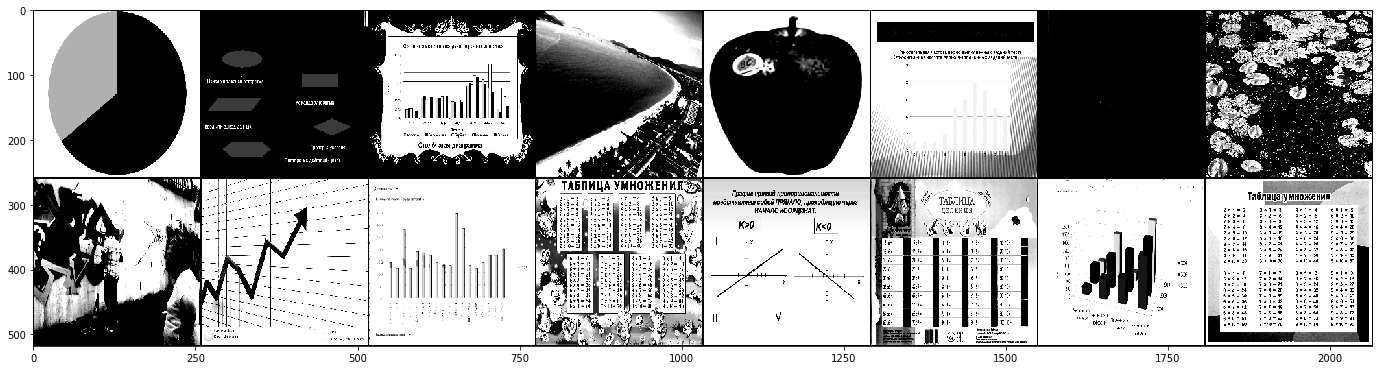

In [ ]:
ensemble.to(device)
ensemble.eval()
with torch.no_grad():
  for step, (data, name) in enumerate(testloader):
    if step < 1:
      continue
    data = data.to(device)
    output = ensemble(data, data)
    output = torch.sigmoid(output)
    
    _, predicted = torch.max(output.data, 1)

    for i, x in enumerate(output.data):
     if torch.max(x) < 0.1:
      predicted[i] = 7

    plt.figure(figsize=(24, 24))
    grid_imgs = torchvision.utils.make_grid(data[:16])
    np_grid_imgs = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')
    break

label_to_name = {1 : 'bar_chart', 2 : 'radar_chart', 3 : 'flow_chart',
                 4 : 'graph', 5 : 'growth_chart', 6 : 'pie_chart',
                 0 : 'table', 7 : 'just_image'}
s = []
labels = np.array(predicted.cpu())
for i in labels[:16]:
  for label, name in label_to_name.items():
    if i == label:
      s.append(name)
      break

print(s[:8])  
print(s[8:16])      
print(labels[:16])

In [ ]:
cifar = resnet18_load()